In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import scipy.stats as sp

path = os.path.abspath("Data")+os.path.sep
filename = path + "water_quality.csv"

In [2]:
# remove outliers using the Interquartile Range (IQR)
# compute first quartile (Q1)
# compute third quartile (Q3)
# compute IQR (Q3 - Q1)
# definition of outlier(x): (x > 3*IQR + Q3) or (x < Q1 - 3*IQR) 
def clean_from_outliers(xs):
    q3, q1 = np.percentile(xs, [75 ,25])
    iqr = q3 - q1
    #isoutlier = lambda x: ((x > (3*iqr + q3)) | (x < (q1 - 3*iqr))) 
    #outliers, normal_data = xs[np.where(isoutlier)], xs[np.where(not(isoutlier))]
    outliers = xs[(xs[:] > 3*iqr + q3) | (xs[:] < q1 - 3*iqr)]
    normal_data = xs[(xs[:] <= 3*iqr + q3) & (xs[:] >= q1 - 3*iqr)]
    
    return normal_data, outliers

In [3]:
def split_on_outliers(frame):
        values = np.array(frame['result'])
        data, outliers = clean_from_outliers(values)
        df_data, df_outliers = frame[frame['result'].isin(data)], frame[frame['result'].isin(outliers)] 
        return df_data, df_outliers

In [4]:
# find the degree of the polynomial that better suits the data.
# iterative approach: increase the polynomial degree until the drop of the squared error is big enough.
# (i.e if the SE is reduced by a big amount continue, otherwise settle for the degree you have )
# maybe it avoids overfitting ???
# abs(SE(k) - SE(k+1)) < epsilon
def selective_fit(xs, ys):
    epsilon = 1 # to check convergence
    squared_error = float('inf') 
    converged = False
    degree = 1
    coefficients = []
    while converged is False:
        coeff_i, se_i, _, _, _ = np.polyfit(xs, ys, degree, full=True)
        if(abs(se_i - squared_error) < epsilon):
            converged = True
        else: 
            coefficients = coeff_i
            squared_error = se_i
            degree += 1
    
    return coefficients, squared_error, degree-1

In [5]:
# fits the scatter points with many polynomial degrees minimizing the squared error, which is reported.
# the length of the 'colors' array determines the number of polynomial degrees to try
def fit_scatter_and_plot(var_x, var_y, xs, ys, out_x, out_y, mix_x, mix_y, unit_x, unit_y):
    coefficients, squared_error, degree = selective_fit(xs, ys)
    #print var_x + ' vs ' + var_y + '. coefficients: ' + str(coefficients)
    p = np.poly1d(coefficients)
    label = '%d$^\circ$, SE = %.2f' %(degree, squared_error)
    plt.plot(np.unique(xs), p(np.unique(xs)), 'black' , label=label)
    
    # report correlation coefficients
    rcoeff = np.corrcoef(xs,ys) # Pearson
    rcoeff = rcoeff[0][1]
    rho, p_value = sp.spearmanr(xs, ys) # rank-order correlation, p_value to test for non-correlation
    plt.plot([], [], 'white', label=r'R = %.2f, $\rho$ = %.2f' % (rcoeff, rho)) # plot empty set just for the labels
    
    #plot scatters
    plt.scatter(xs, ys, c='b', label='normal data', alpha=0.4)
    plt.scatter(out_x, out_y, c='r', label='both outliers', alpha=0.4)
    plt.scatter(mix_x, mix_y, c='orange', label='either outlier', alpha=0.4)
    plt.xlabel(var_x + ' ' + unit_x)
    plt.ylabel(var_y + ' ' + unit_y)
    plt.title(var_x + ' and ' + var_y)
    plt.legend(bbox_to_anchor = (1, 1), loc='best')
    #plt.legend(loc='best', framealpha=0.5)

In [6]:
# further process of the data frame
def split_on_variables(frame, var1, var2):
    selected_rows = frame[(frame['determinand.label'] == var1) | (frame['determinand.label'] == var2)]
    left_df = selected_rows[selected_rows['determinand.label'] == var1]
    right_df = selected_rows[selected_rows['determinand.label'] == var2]
    return left_df, right_df

In [7]:
import operator
data = pd.read_csv(filename)
df = data[['determinand.label', 'result', 'determinand.unit.label', 'water body']]

grouped = df.groupby(['determinand.label', 'determinand.unit.label'])['result'].agg([pd.np.min, pd.np.max, pd.np.mean, pd.np.std, 'count'])

filtered = grouped[grouped['count'] > 15]
pd.DataFrame.sort_values(filtered, "count", ascending=False).head(n=7)

,,amin,amax,mean,std,count
determinand.label,determinand.unit.label,,,,,
Ammonia(N),mg/l,0.030,9.170,0.577450,1.457473,60
N Oxidised,mg/l,0.620,7.290,2.721636,1.856487,55
Nitrite-N,mg/l,0.004,0.208,0.029571,0.038017,55
Nitrate-N,mg/l,0.613,7.190,2.692436,1.833456,55
Temp Water,cel,6.700,21.600,14.259615,2.894570,52
Orthophospht,mg/l,0.062,0.973,0.232942,0.164296,52
pH,phunits,6.850,8.360,7.956304,0.270320,46


In [8]:
# process data frame, select columns of interest.
df2 = data[['determinand.label', 'result', 'determinand.unit.label', 'sample.sampleDateTime', 'Waterbody ID']]
variables = ['Ammonia(N)', 'N Oxidised', 'Nitrate-N', 'Nitrite-N', 'Orthophospht', 'pH', 'Temp Water']

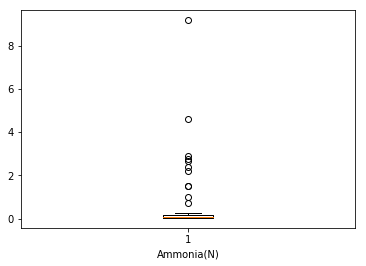

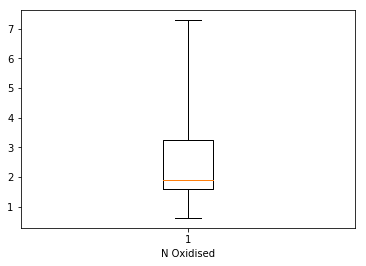

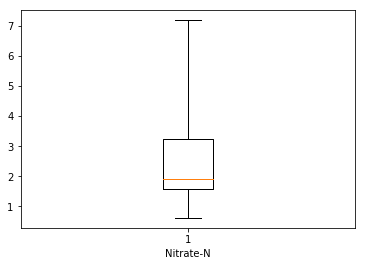

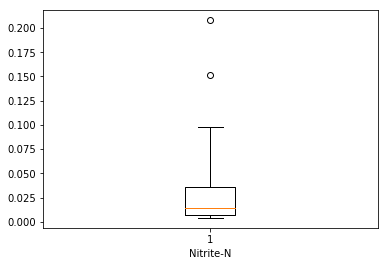

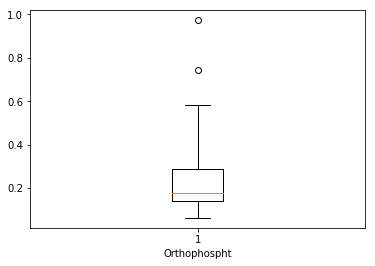

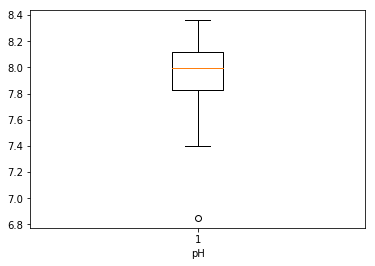

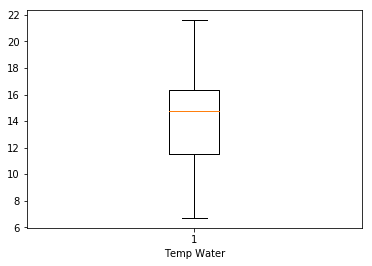

normal data:
3       0.202
12      0.182
196     0.236
223     0.334
247     0.380
282     0.233
294     0.281
306     0.370
317     0.336
353     0.582
391     0.343
472     0.191
521     0.218
536     0.337
548     0.313
560     0.322
569     0.338
584     0.118
609     0.154
620     0.139
854     0.168
866     0.123
878     0.185
890     0.134
902     0.235
913     0.190
926     0.062
938     0.075
953     0.114
962     0.259
978     0.114
1008    0.109
1029    0.187
1056    0.183
1075    0.107
1091    0.138
1107    0.156
1119    0.164
1131    0.165
1144    0.158
1156    0.134
1168    0.147
1180    0.153
1187    0.173
1204    0.130
1214    0.156
1222    0.155
1240    0.140
1251    0.116
1274    0.459
Name: result, dtype: float64
outliers:
331     0.973
1287    0.742
Name: result, dtype: float64


In [9]:
# box plots, to contain the lists of values of the 7 variables
# 2 different box plots to capture the different scales of the variables
"""
vars_1 = ['N Oxidised', 'Nitrate-N', 'Temp Water'] # big spread
vars_2 = ['Ammonia(N)', 'Nitrite-N', 'Orthophospht', 'pH'] # small spread
box_data1, box_data2 = [], []
for var_name in vars_1:
    box_data1.append(df2[df2['determinand.label'] == var_name]['result'])
    
for var_name in vars_2:
    box_data2.append(df2[df2['determinand.label'] == var_name]['result'])    
# returns a dictionary with keys: boxes, medians, whiskers, caps, fliers, means
dict_stats1 = plt.boxplot(box_data1, whis=3, labels=vars_1, vert=True) 
plt.show()
dicts_stats2 = plt.boxplot(box_data2, whis=3, labels=vars_2, vert=True)
plt.show()
"""
for var_name in variables:
    values = np.array(df2[df2['determinand.label'] == var_name]['result'])
    plt.boxplot(values, whis=3, vert=True)
    plt.xlabel(var_name)
    plt.show()
    
values = df2[df2['determinand.label'] == 'Orthophospht']['result']
normal_data, outliers = clean_from_outliers(values)
print 'normal data:'
print normal_data
print 'outliers:'
print outliers

# TODO
# boxplot tutorial here --->>> http://www.physics.csbsju.edu/stats/box2.html
# 1. using the key 'fliers' remove outliers from data points.
# 2. fit polynomial and compute correlation after the outliers are removed.
# 3. in the scatter plots still plot the outliers (different color) along with the normal points.

In [10]:
keys = ['Waterbody ID', 'sample.sampleDateTime']
colors = ['r', 'g', 'b']
figure = 0

for i, y in zip(range(len(variables)), variables):
    for j, x in zip(range(len(variables)), variables):
        if(j > i):
            left_df, right_df = split_on_variables(frame=df2, var1=y, var2=x)
            data_1, outliers_1 = split_on_outliers(left_df)
            data_2, outliers_2 = split_on_outliers(right_df)
            merged_data = pd.merge(data_1, data_2, on=keys) # both normal (0 0)
            merged_outliers = pd.merge(outliers_1, outliers_2, on=keys) # both outliers (1 1)
            df_01 = pd.DataFrame(pd.merge(data_1, outliers_2, on=keys))
            df_10 = pd.DataFrame(pd.merge(outliers_1, data_2, on=keys))
            merged_mixed = pd.concat([df_01, df_10])# either normal or outliers (1 0, 0 1)
            
            # get the ingredients to produce the plot
            xs, ys = merged_data['result_x'], merged_data['result_y']
            out_x, out_y = merged_outliers['result_x'], merged_outliers['result_y']
            mix_x, mix_y = merged_mixed['result_x'], merged_mixed['result_y']
            var_x, var_y = merged_data['determinand.label_x'][0], merged_data['determinand.label_y'][0]
            unit_measure_x, unit_measure_y = merged_data['determinand.unit.label_x'][0], merged_data['determinand.unit.label_y'][0]
            
            plt.figure(figure)
            figure+=1
            fit_scatter_and_plot(var_x, var_y, xs, ys, out_x, out_y, mix_x, mix_y, unit_measure_x, unit_measure_y)

Ammonia(N) vs N Oxidised. coefficients: [ -3.04656365e+03   1.03107227e+03  -6.39222633e+01   3.02436268e+00]
Ammonia(N) vs Nitrate-N. coefficients: [ -3.02438418e+03   1.02371332e+03  -6.36714945e+01   3.01012870e+00]
Ammonia(N) vs Nitrite-N. coefficients: [ 0.30907312  0.00453105]
Ammonia(N) vs Orthophospht. coefficients: [ 0.77433283  0.14563583]
Ammonia(N) vs pH. coefficients: [-0.61852845  8.06443385]
Ammonia(N) vs Temp Water. coefficients: [-389.1048847    98.15263423   10.8164155 ]


/home/carlo/anaconda2/lib/python2.7/site-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


N Oxidised vs Nitrate-N. coefficients: [ 0.98745726  0.00493679]
N Oxidised vs Nitrite-N. coefficients: [ 0.01055271 -0.00393999]
N Oxidised vs Orthophospht. coefficients: [ 0.03016782  0.12504074]
N Oxidised vs pH. coefficients: [-0.00907136  8.04253044]
N Oxidised vs Temp Water. coefficients: [ -0.1277237    1.77975779  -7.86239782  12.34664508   8.47709942]
Nitrate-N vs Nitrite-N. coefficients: [ 0.01059674 -0.00380706]
Nitrate-N vs Orthophospht. coefficients: [ 0.0301216   0.12610514]
Nitrate-N vs pH. coefficients: [-0.00868408  8.04101222]
Nitrate-N vs Temp Water. coefficients: [ -0.13805914   1.90590324  -8.36039288  13.07251798   8.15357859]
Nitrite-N vs Orthophospht. coefficients: [ 2.04875314  0.14622995]
Nitrite-N vs pH. coefficients: [-1.40854484  8.06568345]
Nitrite-N vs Temp Water. coefficients: [ -6.19659509e+04   7.82806004e+03  -2.26938808e+02   1.54935154e+01]
Orthophospht vs pH. coefficients: [-0.37539407  8.0972403 ]
Orthophospht vs Temp Water. coefficients: [ -2.301

/home/carlo/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [11]:
# create a left and right data frame (to separate the variables) and then do an inner join 
# on the water body and date.
# (i.e. pick the measurements that were taken at the same time and place)

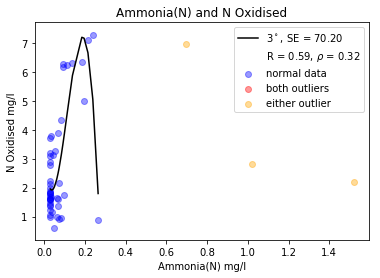

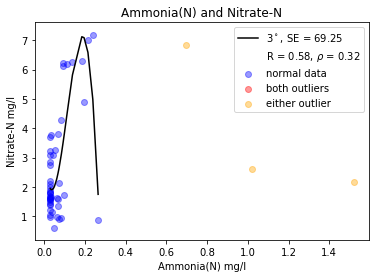

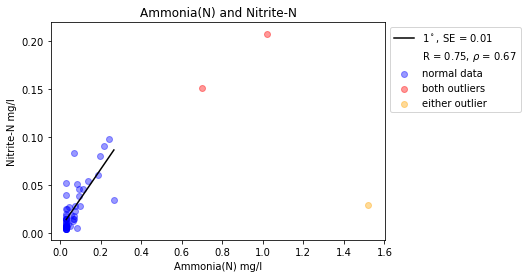

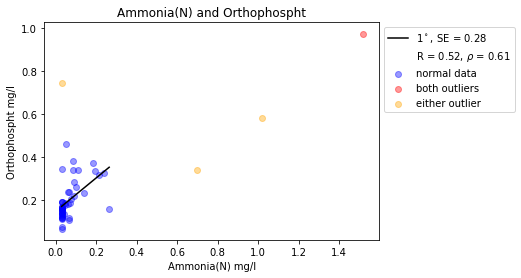

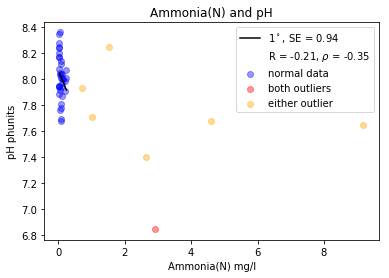

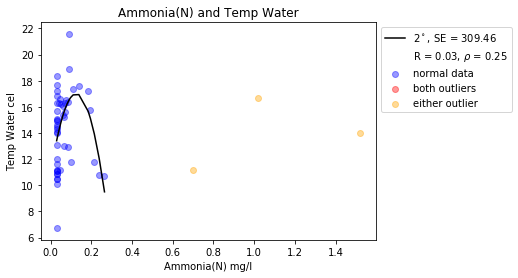

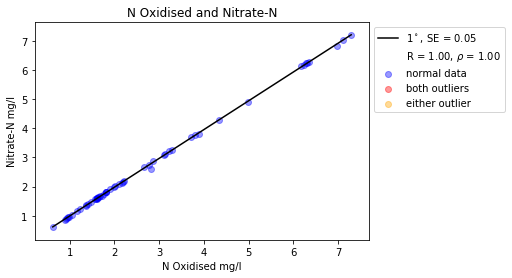

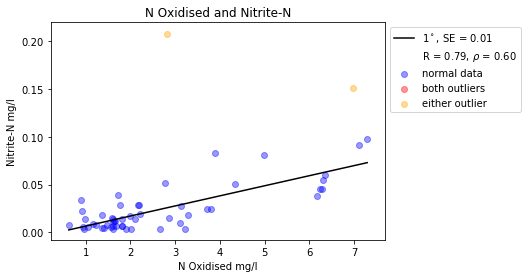

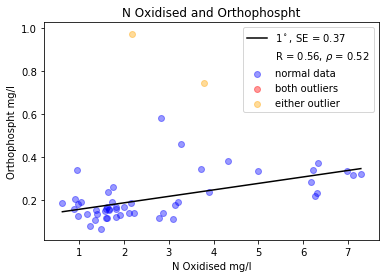

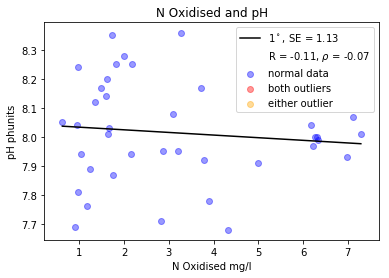

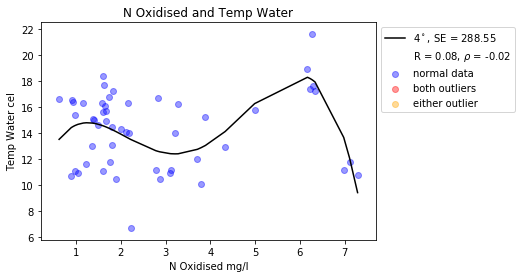

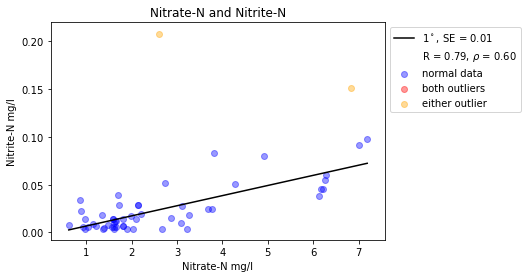

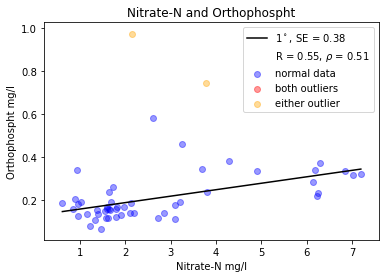

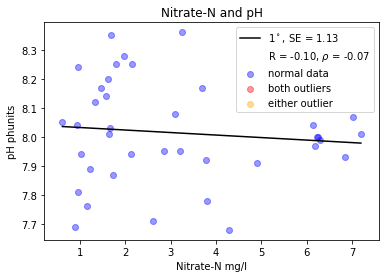

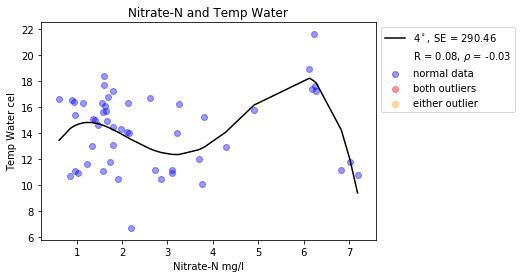

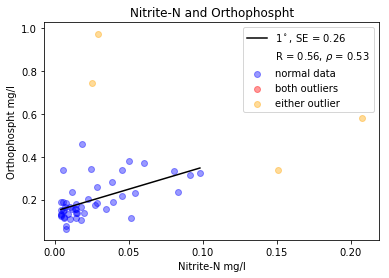

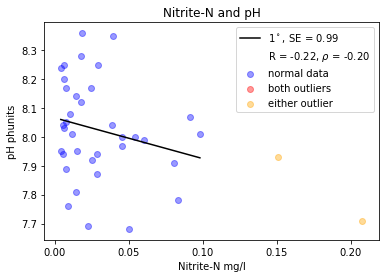

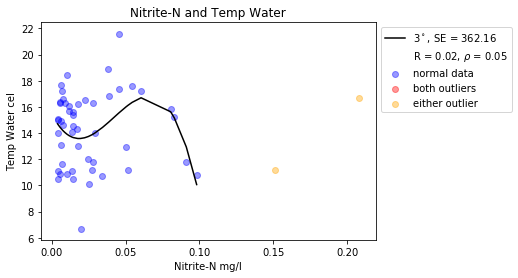

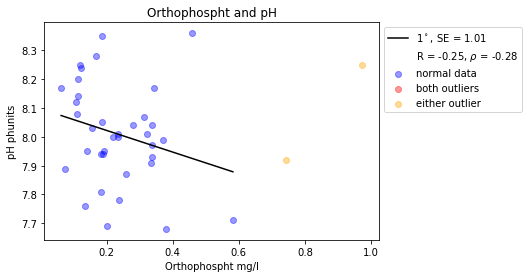

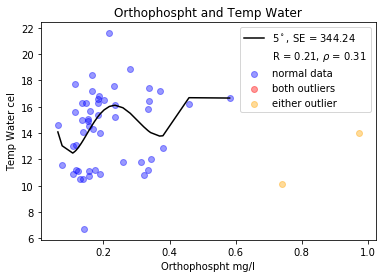

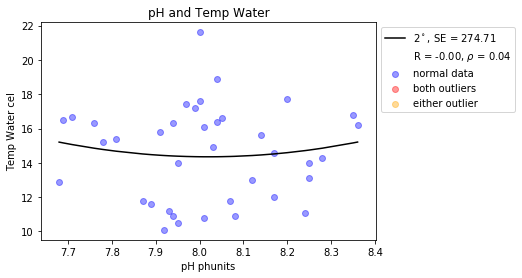

In [12]:
plt.show()
plt.gcf().clear() 